# Estudo de Caso: Previsão do Módulo de Compressibilidade Molecular

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from ase import Atoms
from ase.data import atomic_masses, atomic_numbers
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

In [2]:
# Definição das moléculas
molecule_defs = {
    'H2': ['H', 'H'],
    'O2': ['O', 'O'],
    'N2': ['N', 'N'],
    'CH4': ['C'] + ['H']*4,
    'H2O': ['H', 'H', 'O'],
    'CO2': ['C', 'O', 'O']
}

# Função para calcular massa molecular
def get_molecular_mass(symbols):
    return sum(atomic_masses[atomic_numbers[s]] for s in symbols)

# Geração dos dados
volumes, masses, bulk_moduli, molecule_names = [], [], [], []

for name, symbols in molecule_defs.items():
    mass = get_molecular_mass(symbols)
    for v in np.linspace(10, 100, 20):
        a = v ** (1/3)
        mol = Atoms(symbols, positions=np.zeros((len(symbols), 3)))
        mol.set_cell([a, a, a])
        mol.set_pbc([True, True, True])
        
        volumes.append(v)
        masses.append(mass)
        bulk_moduli.append(np.exp(-v / 50) + np.log1p(mass))
        molecule_names.append(name)

In [3]:
# Entrada com duas features: volume e massa molecular
X = np.array([volumes, masses]).T
y = np.array(bulk_moduli)

# Normalização
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_norm, y, epochs=200, batch_size=16, verbose=0)

C:\Users\Cassio Souza\.conda\envs\compressibilidadev2\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


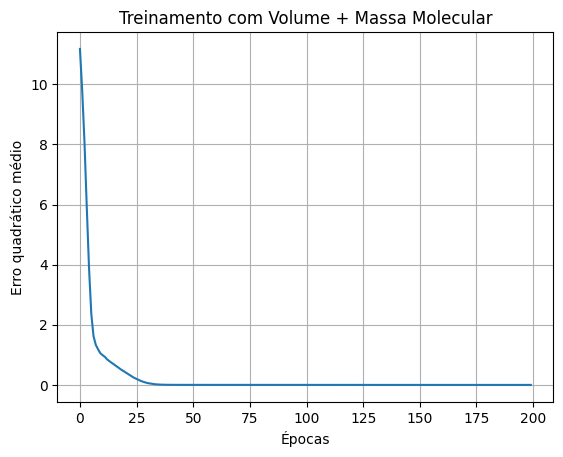

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


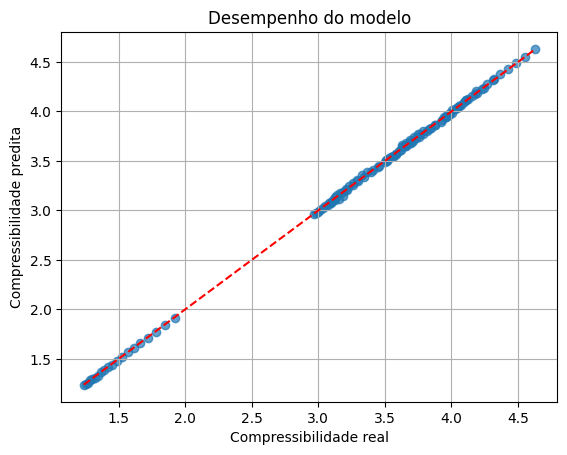

In [5]:
# Curva de perda
plt.plot(history.history['loss'])
plt.xlabel("Épocas")
plt.ylabel("Erro quadrático médio")
plt.title("Treinamento com Volume + Massa Molecular")
plt.grid(True)
plt.show()

# Previsões
y_pred = model.predict(X_norm)
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.xlabel("Compressibilidade real")
plt.ylabel("Compressibilidade predita")
plt.title("Desempenho do modelo")
plt.grid(True)
plt.show()

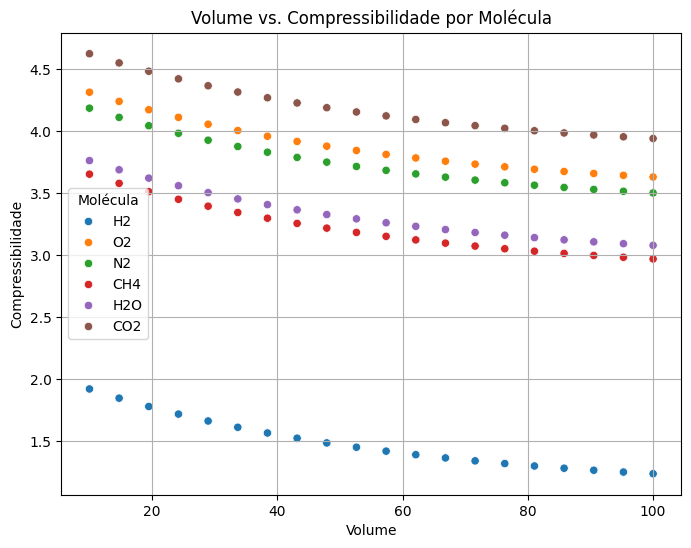

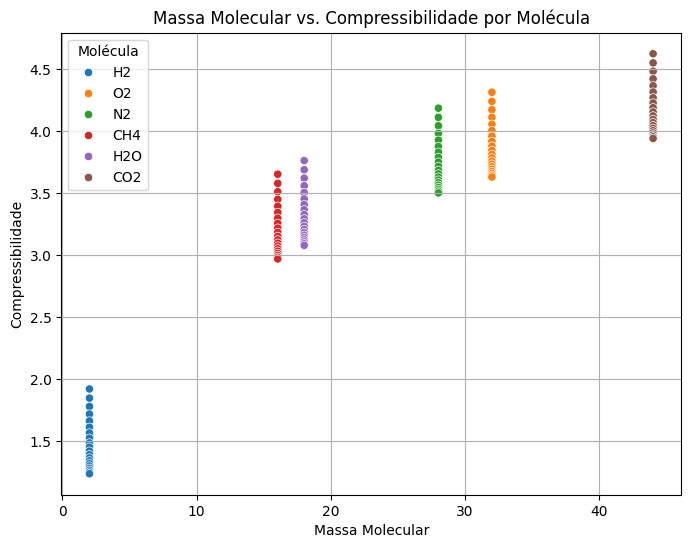

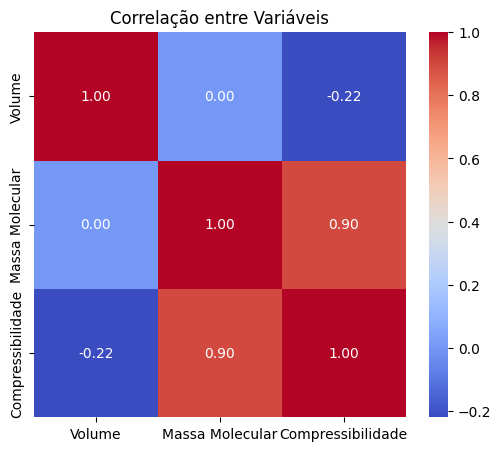

In [6]:
df = pd.DataFrame({
    'Volume': volumes,
    'Massa Molecular': masses,
    'Compressibilidade': bulk_moduli,
    'Molécula': molecule_names
})

# Volume vs. Compressibilidade
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Volume', y='Compressibilidade', hue='Molécula')
plt.title("Volume vs. Compressibilidade por Molécula")
plt.grid(True)
plt.show()

# Massa vs. Compressibilidade
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Massa Molecular', y='Compressibilidade', hue='Molécula')
plt.title("Massa Molecular vs. Compressibilidade por Molécula")
plt.grid(True)
plt.show()

# Correlação entre variáveis
corr = df[['Volume', 'Massa Molecular', 'Compressibilidade']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre Variáveis")
plt.show()

In [7]:
import tensorflow_probability as tfp

# Lista de otimizadores clássicos
optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adam': tf.keras.optimizers.Adam(),
    'Adagrad': tf.keras.optimizers.Adagrad()
}

results = {}
histories = {}

# Função para treinar com otimizadores padrão
def train_standard_optimizer(name, optimizer):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(X_norm, y, epochs=200, batch_size=16, verbose=0)
    final_loss = history.history['loss'][-1]
    results[name] = final_loss
    histories[name] = {
        'model': model,
        'history': history
    }

# Treinamento com otimizadores padrão
for name, opt in optimizers.items():
    train_standard_optimizer(name, opt)

# Treinamento com L-BFGS
def train_lbfgs():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    variables = model.trainable_variables

    def unpack_weights(position):
        """Desempacota o vetor de pesos para os tensores originais."""
        idx = 0
        new_weights = []
        for var in variables:
            shape = var.shape
            size = tf.reduce_prod(shape)
            new_weight = tf.reshape(position[idx:idx+size], shape)
            new_weights.append(new_weight)
            idx += size
        return new_weights

    def loss_fn(position):
        """Calcula a perda e o gradiente dado um vetor de pesos."""
        with tf.GradientTape() as tape:
            new_weights = unpack_weights(position)
            for var, new_val in zip(variables, new_weights):
                var.assign(new_val)
            y_pred = model(X_norm)
            loss = tf.reduce_mean(tf.square(y - tf.squeeze(y_pred)))
        grads = tape.gradient(loss, variables)
        grads_flat = tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)
        return loss, grads_flat

    initial_position = tf.concat([tf.reshape(v, [-1]) for v in variables], axis=0)

    results_lbfgs = tfp.optimizer.lbfgs_minimize(
        loss_fn,
        initial_position=initial_position,
        max_iterations=100
    )

    y_pred = model.predict(X_norm).squeeze()
    loss = np.mean((y - y_pred)**2)
    results['L-BFGS'] = loss
    histories['L-BFGS'] = y_pred

train_lbfgs()

C:\Users\Cassio Souza\.conda\envs\compressibilidadev2\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


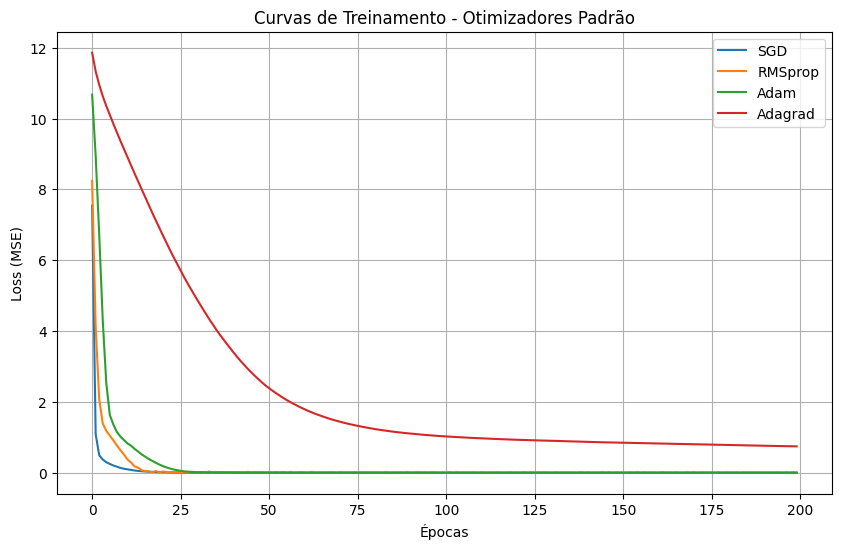


Comparativo de perdas finais:
SGD: Loss final = 0.0003
RMSprop: Loss final = 0.0013
Adam: Loss final = 0.0001
Adagrad: Loss final = 0.7439
L-BFGS: Loss final = 0.0000
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002628AB32D40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


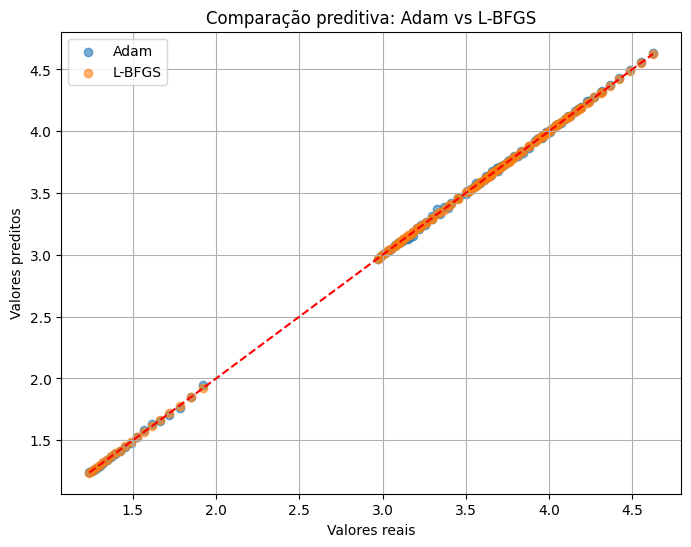

In [8]:
import matplotlib.pyplot as plt

# Curvas de perda dos otimizadores padrão
plt.figure(figsize=(10, 6))
for name, data in histories.items():
    if name != 'L-BFGS':
        plt.plot(data['history'].history['loss'], label=name)
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.title("Curvas de Treinamento - Otimizadores Padrão")
plt.legend()
plt.grid(True)
plt.show()

# Comparativo final de perdas
print("\nComparativo de perdas finais:")
for name, loss in results.items():
    print(f"{name}: Loss final = {loss:.4f}")

# Desempenho preditivo (L-BFGS vs Adam)
plt.figure(figsize=(8, 6))
plt.scatter(y, histories['Adam']['model'].predict(X_norm).squeeze(), alpha=0.6, label='Adam')
plt.scatter(y, histories['L-BFGS'], alpha=0.6, label='L-BFGS')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.xlabel("Valores reais")
plt.ylabel("Valores preditos")
plt.title("Comparação preditiva: Adam vs L-BFGS")
plt.legend()
plt.grid(True)
plt.show()

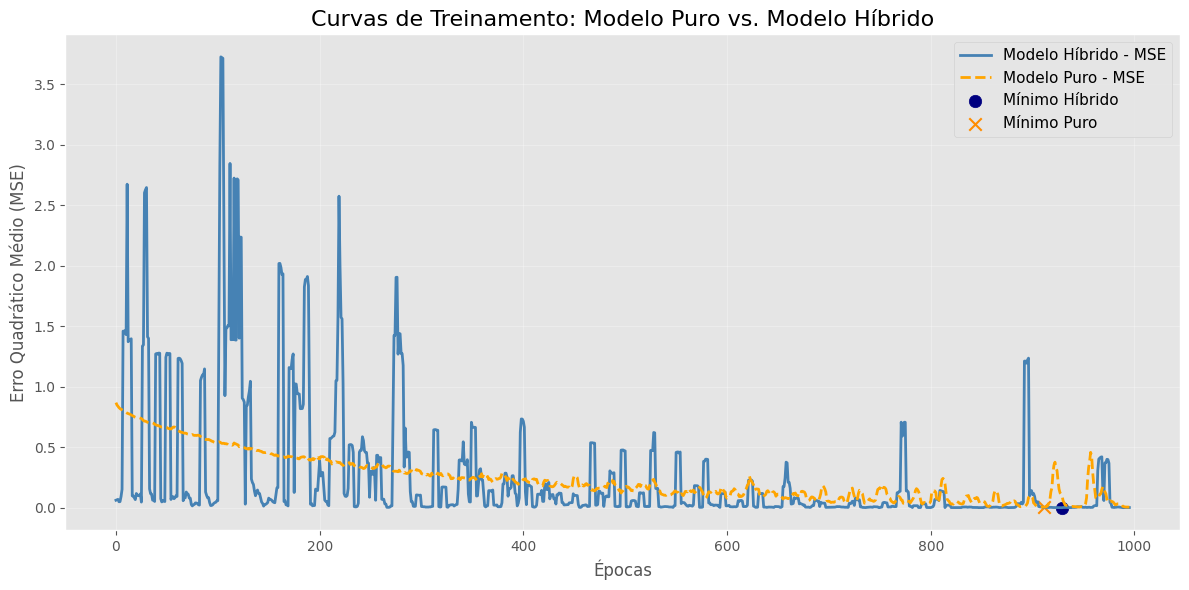

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Dados sintéticos
def gerar_dados(n=1000):
    volume = np.random.uniform(0.1, 10.0, n)
    mass = np.random.uniform(0.1, 100.0, n)
    density = mass / volume
    c = 1500
    compressibility = 1 / (density * c**2)
    return np.hstack([volume.reshape(-1, 1), mass.reshape(-1, 1)]), compressibility.reshape(-1, 1)

# 2. Pré-processamento
X, y = gerar_dados()
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 3. Modelo Puro
model_pure = models.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model_pure.compile(optimizer='adam', loss='mse')
history_pure = model_pure.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=0)

# 4. Modelo Híbrido com penalização física
class HybridModel(tf.keras.Model):
    def __init__(self, base_model, lambda_phys=0.0):
        super().__init__()
        self.base_model = base_model
        self.lambda_phys = tf.Variable(lambda_phys, trainable=False, dtype=tf.float32)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        x, y = data
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            y_pred = self.base_model(x, training=True)
            loss_data = self.loss_fn(y, y_pred)

            # Penalização física: derivada da saída em relação à entrada
            grad = tape.gradient(y_pred, x)
            loss_phys = tf.reduce_mean(tf.square(grad)) if grad is not None else 0.0

            total_loss = loss_data + self.lambda_phys * loss_phys

        grads = tape.gradient(total_loss, self.base_model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.base_model.trainable_variables))

        return {
            "loss": total_loss,
            "loss_data": loss_data,
            "loss_phys": loss_phys
        }

    def call(self, inputs):
        return self.base_model(inputs)

# Instanciando o modelo híbrido
base_model = models.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
hybrid_model = HybridModel(base_model)
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam())

# Fase 1: Treinamento sem física
hybrid_model.lambda_phys.assign(0.0)
history_fase1 = hybrid_model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=0)

# Fase 2: Treinamento com física
hybrid_model.lambda_phys.assign(0.0001)
history_fase2 = hybrid_model.fit(X_train, y_train, epochs=700, batch_size=32, verbose=0)

# 5. Função de suavização
def media_movel(dados, janela=5):
    return np.convolve(dados, np.ones(janela)/janela, mode='valid')

# 6. Gráfico comparativo com flutuações
loss_hibrido = history_fase1.history["loss_data"] + history_fase2.history["loss_data"]
loss_puro = history_pure.history["loss"]

loss_hibrido_suave = media_movel(loss_hibrido)
loss_puro_suave = media_movel(loss_puro)

x_hibrido = np.arange(len(loss_hibrido_suave))
x_puro = np.arange(len(loss_puro_suave))

std_hibrido = np.std(loss_hibrido)
std_puro = np.std(loss_puro)

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

plt.plot(x_hibrido, loss_hibrido_suave, label='Modelo Híbrido - MSE', color='steelblue', linewidth=2)
plt.plot(x_puro, loss_puro_suave, label='Modelo Puro - MSE', color='orange', linestyle='--', linewidth=2)

min_idx_h = np.argmin(loss_hibrido_suave)
min_idx_p = np.argmin(loss_puro_suave)
plt.scatter(min_idx_h, loss_hibrido_suave[min_idx_h], color='navy', marker='o', s=80, label='Mínimo Híbrido')
plt.scatter(min_idx_p, loss_puro_suave[min_idx_p], color='darkorange', marker='x', s=80, label='Mínimo Puro')

plt.title('Curvas de Treinamento: Modelo Puro vs. Modelo Híbrido', fontsize=16)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Erro Quadrático Médio (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


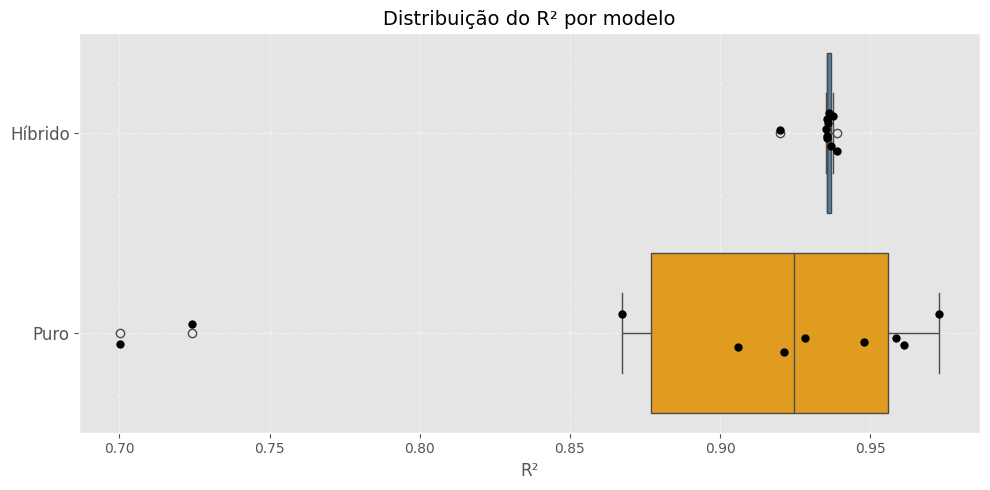

In [10]:
import tensorflow as tf
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Hiperparâmetro da penalização física
λ_phys = 1e-3

# Otimizador para o modelo híbrido
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Simulação de múltiplas execuções
n_runs = 10
r2_puro_list = []
r2_hibrido_list = []

# Histórico de perdas da PINN híbrida
loss_data_history = []
loss_phys_history = []
loss_total_history = []

# Função física: compressibilidade teórica vs predita
def calcular_fisica(x, y_pred):
    massa = x[:, 0:1]
    volume = x[:, 1:2]
    densidade = massa / volume
    compressibilidade_teorica = 1.0 / densidade
    fisica_residual = y_pred - compressibilidade_teorica
    return fisica_residual

for _ in range(n_runs):
    # Re-treina o modelo puro
    model_pure.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Treinamento manual da PINN híbrida com monitoramento
    history = {
        "loss_data": [],
        "loss_phys": [],
        "loss_total": []
    }

    for epoch in range(100):
        with tf.GradientTape() as tape:
            y_pred = hybrid_model(X_train)
            fisica_pred = calcular_fisica(X_train, y_pred)

            loss_data = tf.reduce_mean(tf.square(y_pred - y_train))
            loss_phys = tf.reduce_mean(tf.square(fisica_pred))
            loss_total = loss_data + λ_phys * loss_phys

        grads = tape.gradient(loss_total, hybrid_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, hybrid_model.trainable_variables))

        # Salvar histórico da execução atual
        history["loss_data"].append(loss_data.numpy())
        history["loss_phys"].append(loss_phys.numpy())
        history["loss_total"].append(loss_total.numpy())

    # Armazena os históricos agregados
    loss_data_history.append(history["loss_data"])
    loss_phys_history.append(history["loss_phys"])
    loss_total_history.append(history["loss_total"])

    # Avaliação dos modelos
    y_pred_p = scaler_y.inverse_transform(model_pure.predict(X_test))
    y_pred_h = scaler_y.inverse_transform(hybrid_model.predict(X_test))
    y_true = scaler_y.inverse_transform(y_test)

    r2_puro_list.append(r2_score(y_true, y_pred_p))
    r2_hibrido_list.append(r2_score(y_true, y_pred_h))

# Gráfico de distribuição do R²
plt.figure(figsize=(10, 5))
sns.boxplot(data=[r2_hibrido_list, r2_puro_list], orient='h', palette=['steelblue', 'orange'])
sns.stripplot(data=[r2_hibrido_list, r2_puro_list], orient='h', color='black', size=6, jitter=True)

plt.yticks([0, 1], ['Híbrido', 'Puro'], fontsize=12)
plt.xlabel('R²', fontsize=12)
plt.title('Distribuição do R² por modelo', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


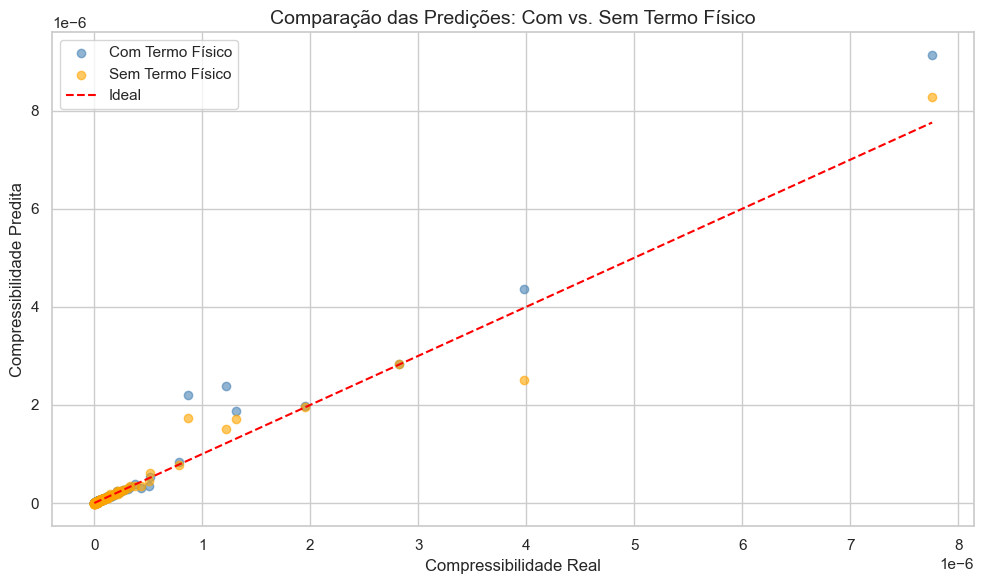

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dados reais e preditos (já normalizados e invertidos)
y_true = scaler_y.inverse_transform(y_test)
y_pred_hybrid = scaler_y.inverse_transform(hybrid_model.predict(X_test))
y_pred_pure = scaler_y.inverse_transform(model_pure.predict(X_test))

# Plot
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')

# Pontos preditos
plt.scatter(y_true, y_pred_hybrid, color='steelblue', alpha=0.6, label='Com Termo Físico')
plt.scatter(y_true, y_pred_pure, color='orange', alpha=0.6, label='Sem Termo Físico')

# Linha ideal
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         linestyle='--', color='red', label='Ideal')

# Estética
plt.title('Comparação das Predições: Com vs. Sem Termo Físico', fontsize=14)
plt.xlabel('Compressibilidade Real', fontsize=12)
plt.ylabel('Compressibilidade Predita', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()